In [7]:
# # !python -c "import torch; print(torch.__version__)"
# # !python -c "import torch; print(torch.version.cuda)"
# # !pip -q install torch-spline-conv==latest+cu102 torch-scatter==latest+cu102 torch-cluster==latest+cu102 torch-sparse==latest+cu102  -f https://pytorch-geometric.com/whl/torch-1.6.0.html

# # #!pip -q install torch-geometric==1.7.0    
# # !pip install -q git+https://github.com/elmahyai/pytorch_geometric_temporal   # remove after merging
# # #!pip -q install torch-geometric-temporal
# %pip install torch-geometric-temporal
# # %pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.1+cu101.html

In [20]:
# %pip --version

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.signal import temporal_signal_split

# GPU support
DEVICE = torch.device('cuda') # cuda
shuffle=True
batch_size = 32

<h1>
<center>A3T-GCN: Attention Temporal Graph
Convolutional Network for Traffic Forecasting</center>
</h1>


## Dataset
- Traffic forecasting dataset based on Los Angeles Metropolitan traffic 
- 207 loop detectors on highways
- March 2012 - June 2012
- From the paper: Diffusion Convolutional Recurrent Neural Network


In [5]:
from torch_geometric_temporal.dataset import METRLADatasetLoader
loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)
print("Dataset type:  ", dataset)
print("Number of samples / sequences: ",  len(dataset.targets))
print(next(iter(dataset))) # Show first sample

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x7f9d67863d90>
Number of samples / sequences:  34249
Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])


#### Data Sample
- 207 nodes
- 2 features per node (speed, time)
- 12 timesteps per bucket (12 x 5 min = 60 min) 
- Labels for 12 future timesteps (normalized speed) --> node regression
- Edge_attr is build based on the distances between sensors + threshold
- Further details: https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/dataset/metr_la.html#METRLADatasetLoader
- Raw data: https://graphmining.ai/temporal_datasets/METR-LA.zip

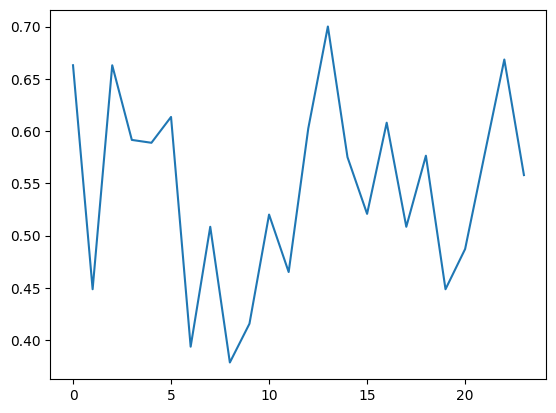

In [6]:
# Visualize traffic over time
sensor_number = 1
hours = 24
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:hours]]
plt.plot(sensor_labels)

# Test Train Split

In [7]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

print("Number of train buckets: ", len(train_dataset.targets))
print("Number of test buckets: ", len(test_dataset.targets))

Number of train buckets:  27399
Number of test buckets:  6850


# Creating DataLoaders


In [8]:
train_input = np.array(train_dataset.features) # (27399, 207, 2, 12)
train_target = np.array(train_dataset.targets) # (27399, 207, 12)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [9]:
test_input = np.array(test_dataset.features) # (, 207, 2, 12)
test_target = np.array(test_dataset.targets) # (, 207, 12)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

## Model

Which model to choose depends on which time-series task you work on. 

- A3TGCN is an extension of TGCN that uses attention 
- The spatial aggregation uses GCN, the temporal aggregation a GRU
- We can pass in periods to get an embedding for several timesteps
- This embedding can be used to predict several steps into the future = output dimension
- We could also do this in a loop and feed it again into the model (would be autoregressive)
- There is only one block here. Other layers also allow stacking???

<html>
<img src="https://i.ibb.co/WxrJQbc/a3tgcn.png", height="300"></img>

# TGCN model
A temporal GCN (T-GCN) model was constructed by combining GCN and GRU. 

n historical time series traffic data were inputted into the T-GCN model to obtain n hidden states (h) that covered spatiotemporal characteristics:{h(t−n), · · · , h(t−1), h(t)}


ut = σ(Wu ∗ (GC(A, Xt), ht−1)) 

rt = σ(Wr ∗ (GC(A, Xt), ht−1)) 

ct = tanh(Wc ∗ (GC(A, Xt), (rt ∗ ht−1)))

ht = ut ∗ ht−1 + (1 − ut) ∗ ct) 


Then, the hidden states were inputted into the attention model to determine the context vector that covers the global traffic variation information. Particularly, the weight of each h was calculated by Softmax using a multilayer perception:{at−n, · · · , at−1, at}.The context vector that covers global traffic variation information is calculated by the weighted sum. 


# A3TGCN Model
The A3TGCN is an extention of the TGCN model by adding an attention mechanism.

The attention mechanism was introduced to re-weight the influence of historical traffic states and thus to capture the global variation trends of traffic state

In [10]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=32, periods=periods,batch_size=batch_size) # node_features=2, periods=12
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 207, 2, 12]  returns h [b, 207, 12]
        h = F.relu(h) 
        h = self.linear(h)
        return h

TemporalGNN(node_features=2, periods=12, batch_size=2)

TemporalGNN(
  (tgnn): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

## Training

In [11]:
%%time
# Create model and optimizers
model = TemporalGNN(node_features=2, periods=12, batch_size=batch_size).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()


print('Net\'s state_dict:')
total_param = 0
for param_tensor in model.state_dict():
    print(param_tensor, '\t', model.state_dict()[param_tensor].size())
    total_param += np.prod(model.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
tgnn._attention 	 torch.Size([12])
tgnn._base_tgcn.conv_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_z.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_z.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_r.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_h.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_h.bias 	 torch.Size([32])
linear.weight 	 torch.Size([12, 32])
linear.bias 	 torch.Size([12])
Net's total params: 6936
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': Non

# Loading the graph once 
because it's a static graph

In [12]:
for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index.to(DEVICE)
    break;

In [13]:
%%time
model.train()

for epoch in range(1):
    step = 0
    loss_list = []
    for encoder_inputs, labels in train_loader:
        y_hat = model(encoder_inputs, static_edge_index)         # Get model predictions
        loss = loss_fn(y_hat, labels) # Mean squared error #loss = torch.mean((y_hat-labels)**2)  sqrt to change it to rmse
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step= step+ 1
        loss_list.append(loss.item())
        if step % 100 == 0 :
            print(sum(loss_list)/len(loss_list))
    print("Epoch {} train RMSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))

0.7568731492757798
0.6450015679001808
0.5936566474040349
0.5689503529667854
0.5493697268366814
0.5383379959066709
0.5318064530832427
0.524598366804421
Epoch 0 train RMSE: 0.5207
CPU times: user 7min 12s, sys: 417 ms, total: 7min 12s
Wall time: 35.8 s


## Evaluation

- Lets get some sample predictions for a specific horizon (e.g. 288/12 = 24 hours)
- The model always gets one hour and needs to predict the next hour

In [14]:
model.eval()
step = 0
# Store for analysis
total_loss = []
for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index)
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    total_loss.append(loss.item())
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)
    

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

Test MSE: 0.5986


### Visualization

- The further away the point in time is, the worse the predictions get
- Predictions shape: [num_data_points, num_sensors, num_timesteps]

In [15]:
sensor = 123
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (32,)


<Axes: >

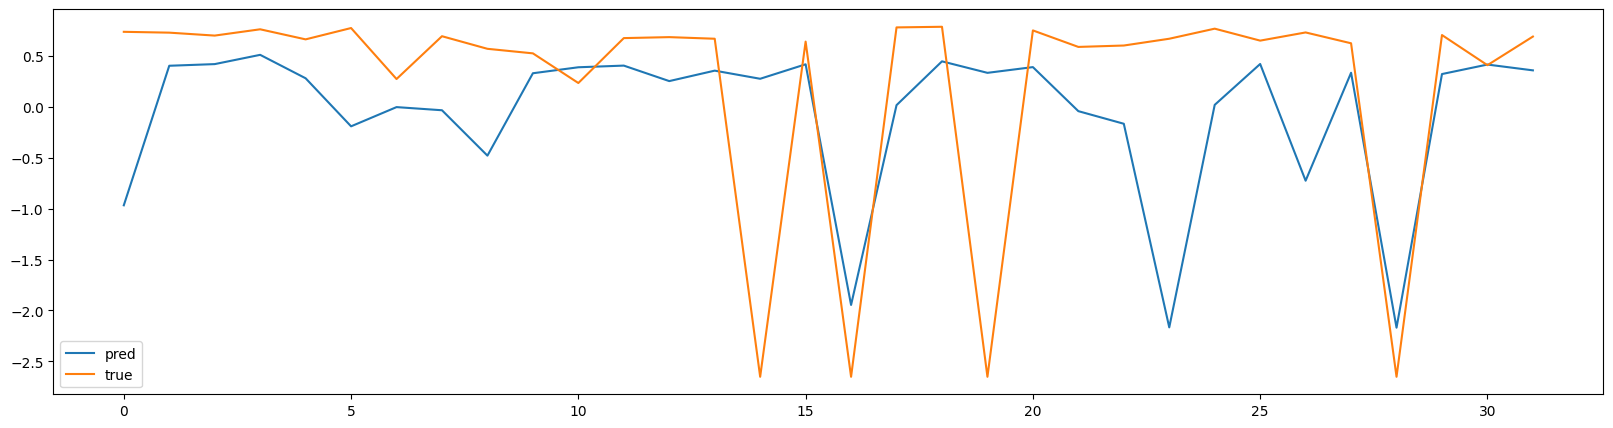

In [17]:
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")

In [34]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.explain import Explainer, PGExplainer

# Define a simple GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.relu = torch.nn.ReLU()

    def forward(self, x, edge_index):
        x = self.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Create dummy dataset (replace with actual PyG dataset)
node_features = torch.rand((10, 3))  # 10 nodes, 3 features per node
edge_index = torch.tensor([[0, 1, 2, 3], [1, 2, 3, 4]], dtype=torch.long)  # 4 edges
target = torch.rand(10)  # 10 target values (regression task)

data = Data(x=node_features, edge_index=edge_index, y=target)
dataset = [data]  # Simulate dataset
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Initialize the model and explainer
model = GCN(in_channels=3, hidden_channels=16, out_channels=1)
explainer = Explainer(
    model=model,
    algorithm=PGExplainer(epochs=30, lr=0.003),
    explanation_type='phenomenon',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    ),
    threshold_config=dict(threshold_type='topk', value=10),
)

# Train the PGExplainer
for epoch in range(30):
    for batch in loader:
        loss = explainer.algorithm.train(
            epoch, model, batch.x, batch.edge_index, target=batch.y)

In [36]:
data_sample = dataset[0]
target_value = data_sample.y.mean()  # Define the target value for the explanation
explanation = explainer(data_sample.x, data_sample.edge_index, target=target_value)

In [37]:
explanation.visualize_feature_importance(top_k=10)
explanation.visualize_graph()

ValueError: The attribute 'node_mask' is not available in 'Explanation' (got ['edge_mask'])